## LightGBM

## 結果  
Ⅰ.  
①まずMedIncのみを特徴量としてtargetを線形回帰予測⇒モデル１を作成  
②その後targetから.predict(x_train_MedInc)を引いて残差を算出  
③残差を目的変数、MedInc以外の特徴量を特徴量として残差を予測⇒モデル２を作成  
④テストデータのMedIncをモデル１に入れて.predict(x_test_MedInc)を算出⇒pred1  
⑤テストデータのMedInc以外の特徴量を特徴量として残差を予測⇒pred2  
⑥pred1とpred2を足して真の予測とする  
RMSE:0.5231193804756671  
そんなに指標は改善してない
  
  
Ⅱ.  
特徴量重要度の一番低いHouseAgeを除いてハイパラ探索後の結果：RMSE_Test_remove 0.4616476242743506  
⇒あまり改善しない

In [1]:
import sklearn.datasets
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as gbm

In [2]:
data=sklearn.datasets.fetch_california_housing()
feature=data.data
target=data.target

In [3]:
x_train, x_test, y_train, y_test = train_test_split(feature, target, train_size=0.7, shuffle=True, random_state=0)

In [4]:
df_train=pd.DataFrame(x_train, columns=data.feature_names)
df_train['target']=y_train
df_test=pd.DataFrame(x_test, columns=data.feature_names)
df_test['target']=y_test

### LightGBMで回帰（ハイパラ探索なし）

In [5]:
lgbm=gbm.LGBMRegressor()
lgbm.fit(x_train, y_train)

LGBMRegressor()

In [6]:
pred_test=lgbm.predict(x_test)

In [7]:
print('RMSE_Test_notpara', mean_squared_error(y_test, pred_test, squared=False))

RMSE_Test_notpara 0.4717400172761787


### LightGBM(ランダムサーチによるハイパラ探索）  
https://qiita.com/c60evaporator/items/351188110f328ff921b9  

In [8]:
scoring = 'neg_root_mean_squared_error'
params = {'reg_alpha': [0.0001, 0.003, 0.1],
          'reg_lambda': [0.0001, 0.1],
             'num_leaves': [2, 3, 4, 6],
             'colsample_bytree': [0.4, 0.7, 1.0],
             'subsample': [0.4, 1.0],
             'subsample_freq': [0, 7],
             'min_child_samples': [0, 2, 5, 10],
             'n_estimators':[5000,10000]
             }

params2 = {'reg_alpha': [0.0001, 0.0002, 0.003],
          'reg_lambda': [0.0001, 0.0002],
          'num_leaves': [4, 5],
          'colsample_bytree': [0.5, 0.7, 0.8],
          'subsample': [0.9, 1.0],
          'min_child_samples': [3, 5, 7],
          'n_estimators':[4000,5000,6000]
             }

params3 = {'reg_alpha': [0.003, 0.004],
          'reg_lambda': [0.0001],
          'num_leaves': [5],
          'colsample_bytree': [0.5, 0.7, 0.8],
          'subsample': [0.9],
          'min_child_samples': [5, 7, 8],
          'n_estimators':[4000, 4500]
             }

In [9]:
rscv=RandomizedSearchCV(gbm.LGBMRegressor(boosting_type='gbdt',random_state=0), 
                        param_distributions=params3, cv=5, scoring=scoring, random_state=1)
rscv.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=LGBMRegressor(random_state=0),
                   param_distributions={'colsample_bytree': [0.5, 0.7, 0.8],
                                        'min_child_samples': [5, 7, 8],
                                        'n_estimators': [4000, 4500],
                                        'num_leaves': [5],
                                        'reg_alpha': [0.003, 0.004],
                                        'reg_lambda': [0.0001],
                                        'subsample': [0.9]},
                   random_state=1, scoring='neg_root_mean_squared_error')

In [10]:
rscv.best_params_

{'subsample': 0.9,
 'reg_lambda': 0.0001,
 'reg_alpha': 0.004,
 'num_leaves': 5,
 'n_estimators': 4500,
 'min_child_samples': 8,
 'colsample_bytree': 0.7}

In [11]:
print(-(rscv.best_score_))

0.4616058415771237


In [12]:
lgbm_best=rscv.best_estimator_.fit(x_train, y_train)
pred_Test_bestpara=lgbm_best.predict(x_test)
print('RMSE_Test_para', mean_squared_error(y_test, pred_Test_bestpara, squared=False))

RMSE_Test_para 0.4503468880159287


### 特徴量重要度  
https://mathmatical22.xyz/2020/04/12/%E3%80%90%E5%88%9D%E5%BF%83%E8%80%85%E5%90%91%E3%81%91%E3%80%91%E7%89%B9%E5%BE%B4%E9%87%8F%E9%87%8D%E8%A6%81%E5%BA%A6%E3%81%AE%E7%AE%97%E5%87%BA-lightgbm-%E3%80%90python%E3%80%91%E3%80%90%E6%A9%9F/

In [13]:
lgbm_best.feature_importances_

array([2516, 1417, 2174, 1812, 1666, 2201, 3219, 2995])

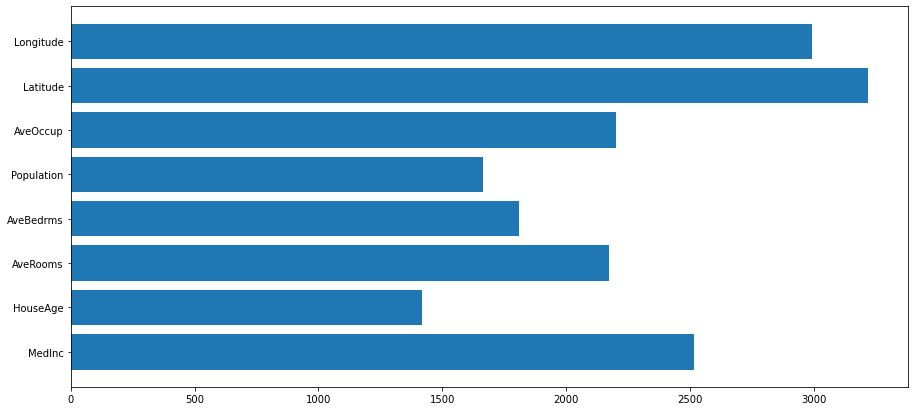

In [14]:
plt.figure(figsize=(15,7))
plt.barh(range(8), lgbm_best.feature_importances_, tick_label=df_train.loc[:,'MedInc':'Longitude'].columns)
plt.show()

### 結果：特徴量重要度を見ると決定木やランダムフォレストの特徴量重要度と値の大きさが違う

## Ⅰ.残差に対してLightGBM  

①まずMedIncのみを特徴量としてtargetを線形回帰予測⇒モデル１を作成  
df_train['MedInc']とdf_train['target']で線形予測

In [15]:
#線形回帰モデルでモデル１を作成
lr=LinearRegression()
lr.fit(df_train['MedInc'].values.reshape(-1,1), df_train['target'])
pred_train_lin=lr.predict(df_train['MedInc'].values.reshape(-1,1))

②その後targetから.predict(x_train_MedInc)を引いて残差を算出  

In [16]:
#yから線形予測の値を引いたy残差を出す
y_residual = df_train['target'] - pred_train_lin

In [36]:
df_train['y_residual'] = y_residual
df_train.corr()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target,y_residual
MedInc,1.000000e+00,-0.120286,0.358696,-0.059447,0.006211,0.002061,-0.085144,-0.010101,0.693247,6.237877e-16
HouseAge,-1.202858e-01,1.000000,-0.162228,-0.077118,-0.299646,0.013599,0.020766,-0.117501,0.104060,2.600908e-01
AveRooms,3.586960e-01,-0.162228,1.000000,0.825315,-0.068875,0.005141,0.105426,-0.025020,0.159166,-1.241831e-01
AveBedrms,-5.944687e-02,-0.077118,0.825315,1.000000,-0.060913,-0.002721,0.068477,0.013276,-0.053642,-1.724732e-02
Population,6.210605e-03,-0.299646,-0.068875,-0.060913,1.000000,0.074756,-0.117672,0.108157,-0.026288,-4.244980e-02
AveOccup,2.060989e-03,0.013599,0.005141,-0.002721,0.074756,1.000000,-0.003685,0.012908,-0.030739,-4.463377e-02
Latitude,-8.514441e-02,0.020766,0.105426,0.068477,-0.117672,-0.003685,1.000000,-0.925163,-0.143918,-1.177914e-01
Longitude,-1.010084e-02,-0.117501,-0.025020,0.013276,0.108157,0.012908,-0.925163,1.000000,-0.045790,-5.381977e-02
target,6.932470e-01,0.104060,0.159166,-0.053642,-0.026288,-0.030739,-0.143918,-0.045790,1.000000,7.207001e-01
y_residual,6.237877e-16,0.260091,-0.124183,-0.017247,-0.042450,-0.044634,-0.117791,-0.053820,0.720700,1.000000e+00


In [38]:
df_train_residual=df_train.drop(['MedInc', 'target','y_residual'], axis=1)
df_train_residual

,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,43.0,3.671480,1.184116,836.0,3.018051,37.77,-122.21
1,17.0,6.478022,1.087912,1387.0,3.810440,33.87,-118.04
2,17.0,2.518000,1.196000,3051.0,3.051000,34.06,-118.28
3,50.0,4.622754,1.161677,606.0,3.628743,36.73,-119.81
4,11.0,6.495068,0.998767,4409.0,2.718249,33.80,-117.79
...,...,...,...,...,...,...,...
14442,20.0,6.000000,1.045662,712.0,3.251142,38.27,-121.26
14443,27.0,5.349282,0.933014,647.0,3.095694,37.48,-120.89
14444,31.0,3.641221,0.941476,704.0,1.791349,36.58,-121.90
14445,34.0,4.540598,1.064103,1052.0,2.247863,33.62,-117.93


In [41]:
lgbm_2 = gbm.LGBMRegressor()

params4 = {'reg_alpha': [0.0001, 0.003, 0.1],
          'reg_lambda': [0.0001, 0.1],
             'num_leaves': [2, 3, 4, 6],
             'colsample_bytree': [0.7, 1.0],
             'subsample': [0.4, 1.0],
             'subsample_freq': [0, 7],
             'min_child_samples': [0, 2, 5],
             'n_estimators':[4500,5000,6000]
             }

In [42]:
%%time
rscv=RandomizedSearchCV(gbm.LGBMRegressor(boosting_type='gbdt',random_state=0),
                        param_distributions=params4, cv=5, scoring='neg_root_mean_squared_error', random_state=2)
rscv.fit(df_train_residual,y_residual)

Wall time: 1min 3s


RandomizedSearchCV(cv=5, estimator=LGBMRegressor(random_state=0),
                   param_distributions={'colsample_bytree': [0.7, 1.0],
                                        'min_child_samples': [0, 2, 5],
                                        'n_estimators': [4500, 5000, 6000],
                                        'num_leaves': [2, 3, 4, 6],
                                        'reg_alpha': [0.0001, 0.003, 0.1],
                                        'reg_lambda': [0.0001, 0.1],
                                        'subsample': [0.4, 1.0],
                                        'subsample_freq': [0, 7]},
                   random_state=2, scoring='neg_root_mean_squared_error')

In [43]:
rscv.best_params_

{'subsample_freq': 0,
 'subsample': 0.4,
 'reg_lambda': 0.0001,
 'reg_alpha': 0.0001,
 'num_leaves': 6,
 'n_estimators': 4500,
 'min_child_samples': 2,
 'colsample_bytree': 0.7}

In [44]:
-rscv.best_score_

0.5213043513892806

相関係数が高いMedIncを除く残りの特徴量でy-y線形予測=y_residualを予測しても  
スコアはRMSE:0.5218921459470307 そんなに高くない

In [45]:
df_train_residual

,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,43.0,3.671480,1.184116,836.0,3.018051,37.77,-122.21
1,17.0,6.478022,1.087912,1387.0,3.810440,33.87,-118.04
2,17.0,2.518000,1.196000,3051.0,3.051000,34.06,-118.28
3,50.0,4.622754,1.161677,606.0,3.628743,36.73,-119.81
4,11.0,6.495068,0.998767,4409.0,2.718249,33.80,-117.79
...,...,...,...,...,...,...,...
14442,20.0,6.000000,1.045662,712.0,3.251142,38.27,-121.26
14443,27.0,5.349282,0.933014,647.0,3.095694,37.48,-120.89
14444,31.0,3.641221,0.941476,704.0,1.791349,36.58,-121.90
14445,34.0,4.540598,1.064103,1052.0,2.247863,33.62,-117.93


In [46]:
#LigthGBMの学習。残差に対する
lgbm_residual = rscv.best_estimator_.fit(df_train_residual, y_residual)

testデータを予測

In [47]:
df_test

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,4.1518,22.0,5.663073,1.075472,1551.0,4.180593,32.58,-117.05,1.369
1,5.7796,32.0,6.107226,0.927739,1296.0,3.020979,33.92,-117.97,2.413
2,4.3487,29.0,5.930712,1.026217,1554.0,2.910112,38.65,-121.84,2.007
3,2.4511,37.0,4.992958,1.316901,390.0,2.746479,33.20,-115.60,0.725
4,5.0049,25.0,4.319261,1.039578,649.0,1.712401,37.79,-122.43,4.600
...,...,...,...,...,...,...,...,...,...
6188,4.1386,2.0,8.821216,1.414779,2826.0,3.368296,33.66,-117.17,1.773
6189,7.8750,30.0,7.550926,0.981481,523.0,2.421296,33.89,-117.91,3.519
6190,2.0658,34.0,5.938144,1.206186,363.0,3.742268,36.56,-119.64,0.925
6191,4.6761,32.0,5.315152,0.981818,917.0,2.778788,37.36,-121.99,2.983


In [48]:
lr=LinearRegression()
lr.fit(df_train['MedInc'].values.reshape(-1,1), df_train['target'])
pred_1=lr.predict(df_test['MedInc'].values.reshape(-1,1))
pred_1.shape

(6193,)

In [49]:
#残差
y_residual_test=  df_test['target'] - pred_1
mean_squared_error(df_test['target'], pred_1, squared=False)

0.851234588517832

In [50]:
df_test_residual=df_test.drop(['MedInc', 'target'], axis=1)
df_test_residual

,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,22.0,5.663073,1.075472,1551.0,4.180593,32.58,-117.05
1,32.0,6.107226,0.927739,1296.0,3.020979,33.92,-117.97
2,29.0,5.930712,1.026217,1554.0,2.910112,38.65,-121.84
3,37.0,4.992958,1.316901,390.0,2.746479,33.20,-115.60
4,25.0,4.319261,1.039578,649.0,1.712401,37.79,-122.43
...,...,...,...,...,...,...,...
6188,2.0,8.821216,1.414779,2826.0,3.368296,33.66,-117.17
6189,30.0,7.550926,0.981481,523.0,2.421296,33.89,-117.91
6190,34.0,5.938144,1.206186,363.0,3.742268,36.56,-119.64
6191,32.0,5.315152,0.981818,917.0,2.778788,37.36,-121.99


In [51]:
pred_2 = lgbm_residual.predict(df_test_residual)

In [54]:
pred_test_lin_residual = pred_1 + pred_2
pred_test_lin_residual.shape

(6193,)

In [55]:
df_test

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,4.1518,22.0,5.663073,1.075472,1551.0,4.180593,32.58,-117.05,1.369
1,5.7796,32.0,6.107226,0.927739,1296.0,3.020979,33.92,-117.97,2.413
2,4.3487,29.0,5.930712,1.026217,1554.0,2.910112,38.65,-121.84,2.007
3,2.4511,37.0,4.992958,1.316901,390.0,2.746479,33.20,-115.60,0.725
4,5.0049,25.0,4.319261,1.039578,649.0,1.712401,37.79,-122.43,4.600
...,...,...,...,...,...,...,...,...,...
6188,4.1386,2.0,8.821216,1.414779,2826.0,3.368296,33.66,-117.17,1.773
6189,7.8750,30.0,7.550926,0.981481,523.0,2.421296,33.89,-117.91,3.519
6190,2.0658,34.0,5.938144,1.206186,363.0,3.742268,36.56,-119.64,0.925
6191,4.6761,32.0,5.315152,0.981818,917.0,2.778788,37.36,-121.99,2.983


In [56]:
print(mean_squared_error(df_test['target'], pred_test_lin_residual, squared=False))

0.5231193804756671


## 特徴量重要度の低いものから外す  
HouseAge

In [67]:
#HouseAgeを除くtrainデータとtestデータの作成
x_train_remove = df_train.drop(['HouseAge','target','y_residual'], axis=1)
y_train_remove = df_train['target']
x_test_remove = df_test.drop(['HouseAge','target'], axis=1)
y_test_remove = df_test['target']

ハイパーパラメータ探索

In [75]:
scoring='neg_root_mean_squared_error'

params5 = {'reg_alpha': [0.0001, 0.003, 0.1],
          'reg_lambda': [0.0001, 0.1],
          'num_leaves': [4, 6],
          'colsample_bytree': [0.7, 1.0],
          'subsample': [0.4, 1.0],
          'subsample_freq': [0, 7],
          'min_child_samples': [0, 2, 5],
          'n_estimators':[4500,5000,6000]
             }

In [72]:
%%time

rscv_2 = RandomizedSearchCV(gbm.LGBMRegressor(boosting_type='gbdt',random_state=0),
                           param_distributions=params5, cv=5, scoring=scoring, random_state=1)
rscv_2.fit(x_train_remove, y_train_remove)

Wall time: 1min 5s


RandomizedSearchCV(cv=5, estimator=LGBMRegressor(random_state=0),
                   param_distributions={'colsample_bytree': [0.7, 1.0],
                                        'min_child_samples': [0, 2, 5],
                                        'n_estimators': [4500, 5000, 6000],
                                        'num_leaves': [2, 3, 4, 6],
                                        'reg_alpha': [0.0001, 0.003, 0.1],
                                        'reg_lambda': [0.0001, 0.1],
                                        'subsample': [0.4, 1.0],
                                        'subsample_freq': [0, 7]},
                   random_state=1, scoring='neg_root_mean_squared_error')

In [74]:
rscv_2.best_params_

{'subsample_freq': 7,
 'subsample': 1.0,
 'reg_lambda': 0.1,
 'reg_alpha': 0.0001,
 'num_leaves': 6,
 'n_estimators': 6000,
 'min_child_samples': 5,
 'colsample_bytree': 0.7}

In [77]:
print(-(rscv_2.best_score_))

0.4723062371685868


In [86]:
pred_Test_remove = rscv_2.predict(x_test_remove)

In [87]:
print('RMSE_Test_remove', mean_squared_error(y_test_remove, pred_Test_remove, squared=False))

RMSE_Test_remove 0.4616476242743506
